<a href="https://colab.research.google.com/github/bini-Bin/painting-classification/blob/main/AIP2_20221370_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Load the train directory containing .csv and images dir from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *

#For plotting my model's structure
from tensorflow.keras.utils import plot_model

#You can import other libraries if you want

In [ ]:
###### DO NOT MODIFY THIS PART
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed) # fix your random seed : In same model, you produce the same result
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
######

In [ ]:
artists = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AIP2/train/artists.csv')
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [ ]:
artists_top

,name,paintings
0,Vincent van Gogh,857
1,Edgar Degas,682
2,Pablo Picasso,419
3,Pierre-Auguste Renoir,316
4,Albrecht Dürer,308
5,Paul Gauguin,291
6,Francisco Goya,271
7,Rembrandt,242
8,Alfred Sisley,239
9,Titian,235


In [ ]:
# Explore images of top artists
images_dir = '/content/drive/MyDrive/Colab Notebooks/AIP2/train/images' #Type Your Own Data Directory
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:    
    if os.path.exists(os.path.join(images_dir, name)):  # images_idr: directory folder // name: label (y) 
        print("find -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Vincent_van_Gogh
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Edgar_Degas
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Pablo_Picasso
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Pierre-Auguste_Renoir
Did not find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Albrecht_Dürer
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Paul_Gauguin
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Francisco_Goya
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Rembrandt
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Alfred_Sisley
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Titian
find --> /content/drive/MyDrive/Colab Notebooks/AIP2/train/images/Marc_Chagall


In [ ]:
# I tried 64, 32, 16 batch_sizes
batch_size = 16

# I tried (32, 32), (64, 64), (128, 128) input_shape
input_shape = (128, 128)
n_classes = artists_top.shape[0]

#Image data generate with validation data fraction of 0.2 and data rescale 1/255.
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=10 # For a variety of learning, I added rotation.
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 2861 images belonging to 11 classes.
Found 710 images belonging to 11 classes.
Total number of batches = 178 and 44


In [ ]:
#######################
# Make your own model #
#######################

#Your Own code

model = Sequential([
    Conv2D(64, 3, padding="same", input_shape=(input_shape[0], input_shape[1], 3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(11, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001)) # To reduce overfitting, I added L2 regularizer
])


In [ ]:
# I tried 0.01, 0.001, 0.0001, 0.00001 for learing_rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
#training

n_epoch = 20

history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch) #you can add kwargs if you want

<ipython-input-10-a010a3e6fe36>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,


Epoch 1/20
178/178 [==============================] - 846s 5s/step - loss: 2.1136 - accuracy: 0.2439 - val_loss: 2.0665 - val_accuracy: 0.2486
Epoch 2/20
178/178 [==============================] - 75s 421ms/step - loss: 1.8326 - accuracy: 0.3533 - val_loss: 1.8343 - val_accuracy: 0.4233
Epoch 3/20
178/178 [==============================] - 76s 427ms/step - loss: 1.6549 - accuracy: 0.4130 - val_loss: 1.7344 - val_accuracy: 0.4233
Epoch 4/20
178/178 [==============================] - 75s 420ms/step - loss: 1.5349 - accuracy: 0.4573 - val_loss: 1.6468 - val_accuracy: 0.4432
Epoch 5/20
178/178 [==============================] - 75s 423ms/step - loss: 1.4464 - accuracy: 0.5012 - val_loss: 1.5623 - val_accuracy: 0.4858
Epoch 6/20
178/178 [==============================] - 76s 426ms/step - loss: 1.3863 - accuracy: 0.5262 - val_loss: 1.5177 - val_accuracy: 0.4801
Epoch 7/20
178/178 [==============================] - 75s 421ms/step - loss: 1.2912 - accuracy: 0.5592 - val_loss: 1.4674 - val_accu

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)       0

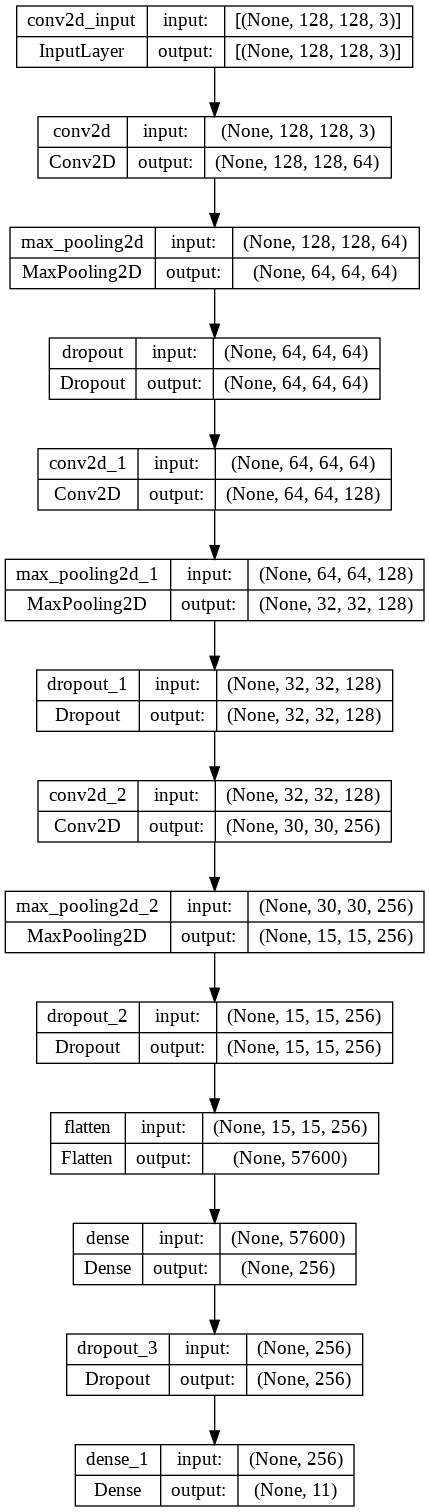

In [ ]:
# model's structure
plot_model(model, to_file='model_shapes.png', show_shapes=True)

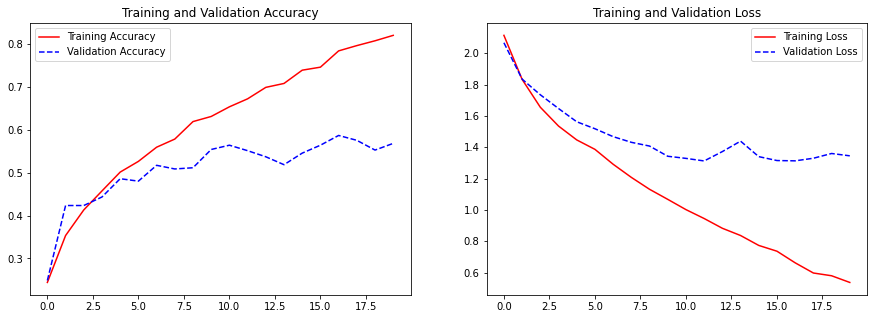

In [ ]:
his = {}
his['loss'] = history.history['loss']
his['accuracy'] = history.history['accuracy'] 
his['val_loss'] = history.history['val_loss']
his['val_accuracy'] = history.history['val_accuracy']

# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(his)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/AIP2/models")